#### Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
import math

#### Func to load data in

In [2]:
def load_data(path):
    data = pd.read_csv(path)
    return data

###### Call load_data func

In [3]:
path = "/Users/Opeyemi/Desktop/Machine Learning/homeworks/ia1/IA1_train.csv"
data = load_data(path)

#### Data preprocessing function

In [24]:
def preprocess_data(data, normalize, drop_sqrt_living15):
    
    # (a) remove the id column
    data = data.iloc[:, 1:]
    #print("data after id column removal:", data.head(3), "\n")
    
    # (b) split the date feature into seperate columns
    data.date = pd.to_datetime(data.date)
    data['month'] = data['date'].dt.month
    data['year'] = data['date'].dt.year
    data['day'] = data['date'].dt.day
    data = data.iloc[:, 1:]
    #print("data after date column splitting:", data.head(3), "\n")
    
    # (c) create a dummy column of all ones as the bias/intercept term
    data['dummy'] = np.ones((data.shape[0], 1), dtype="int32")
    #print("data with dummy column inserted:", data.head(3))
    
    # (d) replace yr_renovated column with age_since_renovated column
    data.loc[data['yr_renovated'] == 0, 'age_since_renovated'] = data['year'] - data['yr_built']
    data.loc[data['yr_renovated'] != 0, 'age_since_renovated'] = data['year'] - data['yr_renovated']
    data = data.drop('yr_renovated', axis=1)
    all_columns = ['dummy', 'month', 'day', 'year', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 
                       'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 
                       'age_since_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'price']
    data = data[all_columns]
    #print("data after modifying yr-renovated column:", data.head(3), "\n")
    
    # split the data into X and y_labels
    X = data.drop("price", axis=1)
    y = data.price
    
    # (e) normalize dataset if normalize argument is set to true
    if normalize is True:
        column_mean = [0] * data.shape[1]
        column_std = [0] * data.shape[1]
        
        for index, column in enumerate(data.columns):
            if column == 'waterfront' or column == 'price' or column == 'dummy':
                continue
            column_mean[index] = data[column].mean()
            column_std[index] = data[column].std()
            data[column] = (data[column] - column_mean[index]) / column_std[index]
        
        if drop_sqrt_living15 is True:
            return data.drop("sqft_living15", axis=1), column_mean, column_std
        
        return data, column_mean, column_std      
        
    return data

#### Batch gradient descent

In [5]:
def gradient_train(X, y, lr, stopping_threshold, itr=float("inf")):
    
    counter = 0
    weight = np.zeros(X.shape[1])
    loss_list = [np.power(X.dot(weight) - y, 2).mean()]
    
    while counter < itr:
        delta_w = X.multiply((X.dot(weight) - y), axis=0).mean() * 2
        weight = weight - lr * delta_w
        loss = np.power(X.dot(weight) - y, 2).mean()
        loss_list.append(loss)
        
        if np.linalg.norm(delta_w) <= stopping_threshold or loss == np.nan or loss == float("inf"):
            break
            
        counter += 1
        
    print("itr={}, lr={}, loss={}".format(counter, lr, loss))
    return weight, loss_list

#### Part 1(a) Train the gradient descent algorithm using different learning rates using the preprocessed and normalized data

In [6]:
train_data, column_mean, column_std = preprocess_data(data, normalize=True, drop_sqrt_living15=False)

itr=30, lr=10000.0, loss=inf
itr=37, lr=1000.0, loss=inf
itr=49, lr=100.0, loss=inf
itr=74, lr=10.0, loss=inf
itr=150, lr=1.0, loss=inf
itr=4000, lr=0.1, loss=3.757897232495061
itr=4000, lr=0.01, loss=3.7936349279621555
itr=4000, lr=0.001, loss=3.8524206023677396
itr=4000, lr=0.0001, loss=10.190788126232311
itr=4000, lr=1e-05, loss=33.39857210738694


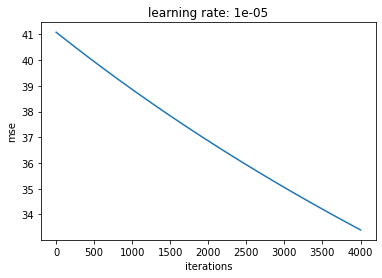

In [7]:
lr_arr = [1e4, 1e3, 1e2, 1e1, 1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
for lr in lr_arr:
    weight, mse = gradient_train(train_data.drop('price', axis=1), train_data['price'], lr, 1e-8, itr=4000)
    dict = {'iterations': list(range(len(mse))), 'mse': mse}
    df_iter_mse = pd.DataFrame(dict)
    
    plt.clf()
    iter_mse = sns.lineplot(data=df_iter_mse, x="iterations", y="mse").set_title('learning rate: ' + str(lr))
    fig_iter_mse = iter_mse.get_figure()
    
    mse_plot_save_path = '/Users/Opeyemi/Desktop/Machine Learning/homeworks/ia1/figures/' + "normalized_lr_" + str(lr) + '.jpg'
    
    fig_iter_mse.savefig(mse_plot_save_path)

#### Part 1(b) Compute and report the MSE of final model on the validation data

In [38]:
# load in the validation data
path = "/Users/Opeyemi/Desktop/Machine Learning/homeworks/ia1/IA1_dev.csv"
dev = load_data(path)

# pre-process the validation data
dev = dev.iloc[:, 1:] #remove the id column

# split the date column into three
dev.date = pd.to_datetime(dev.date)
dev['month'] = dev['date'].dt.month
dev['year'] = dev['date'].dt.year
dev['day'] = dev['date'].dt.day
dev = dev.iloc[:, 1:]

# create a dummy column for the bias/intercept
dev['dummy'] = np.ones(dev.shape[0])

# replace yr_renovated column with age_since_renovated column
dev.loc[dev['yr_renovated'] == 0, 'age_since_renovated'] = dev['year'] - dev['yr_built']
dev.loc[dev['yr_renovated'] != 0, 'age_since_renovated'] = dev['year'] - dev['yr_renovated']
dev = dev.drop('yr_renovated', axis=1)

all_columns = ['dummy', 'month', 'day', 'year', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 
                   'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 
                   'age_since_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'price']

dev_1 = dev[all_columns]

# normalize the dev dataset
for index, column in enumerate(dev_1.columns):
    if column == 'waterfront' or column == 'price' or column == 'dummy':
        continue
    dev_1[column] = (dev_1[column] - column_mean[index]) / column_std[index]
    
# compute the mse func
def compute_mse(X, y, weights):
    return np.power(X.dot(weights) - y, 2).mean()

# report the mse of learned model on the validation data
convergent_lrs = [1e-1, 1e-2, 1e-3, 1e-4]
weight_list =  []
for lr in convergent_lrs:
    weight, mse = gradient_train(dev_1.drop('price', axis=1), dev_1['price'], lr, 1e-8, itr=4000)
    weight_list.append(weight)

for index, weight in enumerate(weight_list):
    print("learning rate={}, MSE={}".format(convergent_lrs[index], compute_mse(dev_1.drop("price", axis=1), dev_1['price'], weight)))

itr=4000, lr=0.1, loss=4.356874833670252
itr=4000, lr=0.01, loss=4.461375006628152
itr=4000, lr=0.001, loss=4.632524467113898
itr=4000, lr=0.0001, loss=11.073620887650685
learning rate=0.1, MSE=4.356874833670252
learning rate=0.01, MSE=4.461375006628152
learning rate=0.001, MSE=4.632524467113898
learning rate=0.0001, MSE=11.073620887650685


#### Part 1(c) Report the learned weights for each feature of the model that performs best on the validation data

In [9]:
# the best model has learning rate of 0.1
weight, mse = gradient_train(train_data.drop('price', axis=1), train_data['price'], 0.1, 1e-8, itr=4000)
print("learning rate={}, MSE={}".format(0.1, compute_mse(dev.drop("price", axis=1), dev['price'], weight)), "\n")

print(weight, "\n")
print("The most positive weight feature is {} and The most negative weight feature is {}".format(
     train_data.drop("price", axis=1).columns[np.argmax(weight)], train_data.drop("price", axis=1).columns[np.argmin(weight)]))

itr=4000, lr=0.1, loss=3.757897232495061
learning rate=0.1, MSE=4.5053553515377285 

dummy                  5.334911
month                  0.054940
day                   -0.050598
year                   0.173781
bedrooms              -0.281475
bathrooms              0.339022
sqft_living            0.763553
sqft_lot               0.058188
floors                 0.018143
waterfront             3.965003
view                   0.448146
condition              0.199874
grade                  1.115143
sqft_above             0.756488
sqft_basement          0.155253
yr_built              -0.883467
age_since_renovated   -0.102649
zipcode               -0.263433
lat                    0.836586
long                  -0.303795
sqft_living15          0.143490
sqft_lot15            -0.099304
dtype: float64 

The most positive weight feature is dummy and The most negative weight feature is yr_built


#### Part 2(a) - Training with non-normalized data

itr=13, lr=10, loss=inf
itr=14, lr=1, loss=inf
itr=16, lr=0.1, loss=inf
itr=18, lr=0.01, loss=inf
itr=20, lr=0.001, loss=inf
itr=24, lr=0.0001, loss=inf
itr=28, lr=1e-05, loss=inf
itr=35, lr=1e-06, loss=inf
itr=65, lr=1e-08, loss=inf
itr=117, lr=1e-09, loss=inf
itr=4000, lr=1e-10, loss=5.0421842085316194e+100
itr=4000, lr=1e-11, loss=10.85034565905031
itr=4000, lr=1e-12, loss=12.071950445691549
itr=4000, lr=1e-13, loss=12.214437783245735
itr=4000, lr=1e-14, loss=17.975912263640883
itr=4000, lr=1e-15, loss=36.770300418781545
itr=4000, lr=1e-16, loss=40.616785287271014
itr=4000, lr=1e-12, loss=12.071950445691549
learning rate=1e-12, MSE=14.178753778371513 

dummy                  5.352510e-10
month                  3.640779e-09
day                    2.363169e-10
year                   1.078074e-06
bedrooms               9.793863e-09
bathrooms              1.206408e-08
sqft_living            1.835938e-05
sqft_lot               4.504619e-06
floors                 4.860859e-09
waterfront  

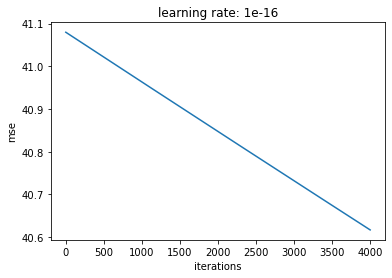

In [32]:
# fetch the non-normalized data
train_data2 = preprocess_data(data, normalize=False, drop_sqrt_living15=False)

# train the non-normalized data with different learning rates
lr_arr = [10, 1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15, 1e-16]
for lr in lr_arr:
    weight, mse = gradient_train(train_data2.drop('price', axis=1), train_data2['price'], lr, 1e-8, itr=4000)
    dict = {'iterations': list(range(len(mse))), 'mse': mse}
    df_iter_mse = pd.DataFrame(dict)
    
    plt.clf()
    iter_mse = sns.lineplot(data=df_iter_mse, x="iterations", y="mse").set_title('learning rate: ' + str(lr))
    fig_iter_mse = iter_mse.get_figure()
    
    mse_plot_save_path = '/Users/Opeyemi/Desktop/Machine Learning/homeworks/ia1/figures/' + "non_normalized_lr_" + str(lr) + '.jpg'
    fig_iter_mse.savefig(mse_plot_save_path)
    
# compute the MSE of the best model on the validation dataset
path = "/Users/Opeyemi/Desktop/Machine Learning/homeworks/ia1/IA1_dev.csv"
dev = load_data(path) # reload the dev dataset

# pre-process the validation data
dev = dev.iloc[:, 1:] #remove the id column

# split the date column of the validation dataset into three
dev.date = pd.to_datetime(dev.date)
dev['month'] = dev['date'].dt.month
dev['year'] = dev['date'].dt.year
dev['day'] = dev['date'].dt.day
dev = dev.iloc[:, 1:]

# create a dummy column for the bias/intercept
dev['dummy'] = np.ones(dev.shape[0])

# replace yr_renovated column with age_since_renovated column
dev.loc[dev['yr_renovated'] == 0, 'age_since_renovated'] = dev['year'] - dev['yr_built']
dev.loc[dev['yr_renovated'] != 0, 'age_since_renovated'] = dev['year'] - dev['yr_renovated']
dev = dev.drop('yr_renovated', axis=1)

all_columns = ['dummy', 'month', 'day', 'year', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 
                   'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 
                   'age_since_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'price']

dev = dev[all_columns]

# evaluate the best learned model on the validation dataset
# the best model has learning rate of 1e-12
weight, mse = gradient_train(train_data2.drop('price', axis=1), train_data['price'], 1e-12, 1e-8, itr=4000)
print("learning rate={}, MSE={}".format(1e-12, compute_mse(dev.drop("price", axis=1), dev['price'], weight)), "\n")

print(weight, "\n")
print("The most positive weight feature is {} and The most negative weight feature is {}".format(
     train_data2.drop("price", axis=1).columns[np.argmax(weight)], train_data2.drop("price", axis=1).columns[np.argmin(weight)]))


####### Non-normalized data requires the use of smaller learning rates to converge as non-normalized input features has the risk of exploding gradients. As some of the features have much larger values compared to others, the gradients for weights related to feature with large values will be significantly larger than the gradients for the other features during training and this can hinder the gradient descent algorithm from coverging to a minima. This is where the use of small learning rates can help to ensure convergence on the non-normalized features of our dataset. 

#### Part 2(b) - Redundancy in features

In [34]:
dev.head(3)

,dummy,month,day,year,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,sqft_above,sqft_basement,yr_built,age_since_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,1.0,8,6,2014,4,1.00,1520,9800,1.5,0,...,1520,0,1971,43.0,98034,47.7303,-122.236,1540,7700,3.8900
1,1.0,3,16,2015,3,2.25,1800,15903,1.0,0,...,1340,460,1986,29.0,98038,47.3813,-122.043,2000,15233,3.3562
2,1.0,12,12,2014,3,1.50,1780,5000,1.0,0,...,1030,750,1958,56.0,98118,47.5168,-122.256,1780,7500,4.2000


In [37]:
# fetch the normalized data with the 'sqft_living15' column dropped
train_data3, column_mean3, column_std3 = preprocess_data(data, normalize=True, drop_sqrt_living15=True)

#train the model with the new dataset and compute the validation mse and the learned weights
weight, mse = gradient_train(train_data3.drop('price', axis=1), train_data3['price'], 0.1, 1e-8, itr=4000)
print("learning rate={}, MSE={}".format(0.1, compute_mse(dev_1.drop(['price', 'sqft_living15'], axis=1), dev_1['price'], weight)), "\n")
print(weight)

itr=4000, lr=0.1, loss=3.764688470320703
learning rate=0.1, MSE=4.521144879576144 

dummy                  5.335026
month                  0.055064
day                   -0.050384
year                   0.172789
bedrooms              -0.283117
bathrooms              0.333352
sqft_living            0.803578
sqft_lot               0.051960
floors                 0.004418
waterfront             3.947974
view                   0.462525
condition              0.195855
grade                  1.157613
sqft_above             0.797647
sqft_basement          0.160526
yr_built              -0.874220
age_since_renovated   -0.090588
zipcode               -0.272844
lat                    0.841366
long                  -0.286782
sqft_lot15            -0.095519
dtype: float64
